/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


> Average Accuracy across 10-folds: 94.40% (+/- 0.41%)


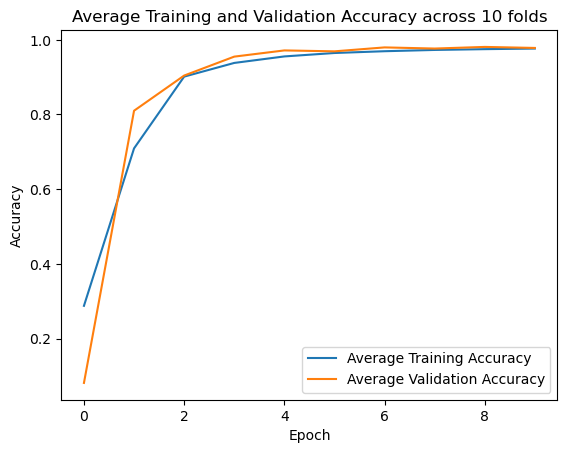

1045/1045 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step
                   precision    recall  f1-score   support

          feature       0.99      1.00      0.99      8359
            issue       0.96      0.99      0.97      8359
  user_experience       0.98      0.98      0.98      8359
other_information       0.98      0.94      0.96      8359

         accuracy                           0.98     33436
        macro avg       0.98      0.98      0.98     33436
     weighted avg       0.98      0.98      0.98     33436



In [1]:
# GRU Model for Dataset

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Import RandomOverSampler from imblearn to handle class imbalance
from imblearn.over_sampling import RandomOverSampler

# 1. Load and Preprocess the dataset
df = pd.read_csv('requirment.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

y = pd.get_dummies(df['category']).values

# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the GRU model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
acc_per_fold = []
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Final Evaluation
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=df['category'].unique()))
